# Preparing the environment

### Connecting to Kaggle via Colab

In [ ]:
#install Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"houssemmedinedrissi","key":"112c75518e7766c38348300dd6c09399"}'}

In [ ]:
#create a kaggle folder
!mkdir ~/.kaggle

In [ ]:
#copy kaggle.json file into created folder
!cp kaggle.json ~/.kaggle/ 

In [ ]:
#Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

### Importing dataset from Kaggle

In [ ]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip brain-tumor-mri-dataset.zip

## Exploring dataset 

### Import Necessary Libraries

In [ ]:
pip install scikit-plot

In [ ]:
import numpy as np
import os
import pandas as pd
import cv2
from tqdm import tqdm
import io

import seaborn as sns
import matplotlib.pyplot as plt
# Shuffle arrays or sparse matrices in a consistent way
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers as opt
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

### Reading the Dataset

In [ ]:
train_dir = '/content/Training'
test_dir = '/content/Testing'

train_paths = []
train_labels = []

test_paths = []
test_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+"//" +label):
        test_paths.append(test_dir + '//'+label+ '//'+image)
        test_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
test_paths, test_labels = shuffle(test_paths, test_labels)

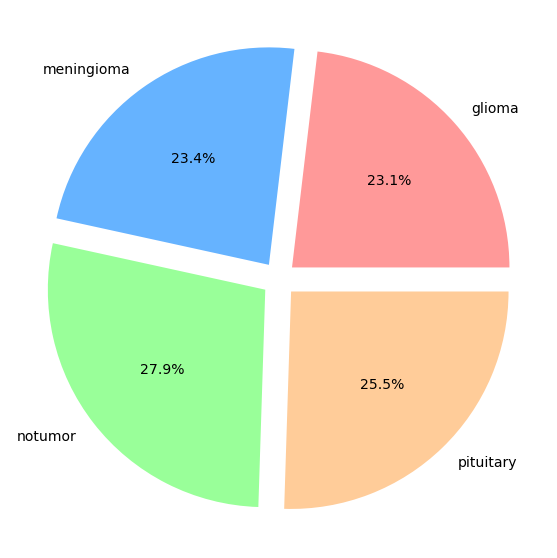

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


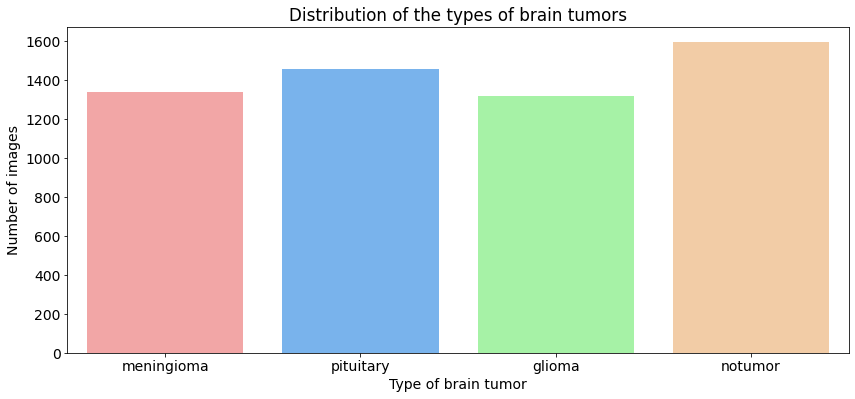

In [ ]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie([len(os.listdir(train_dir+"//" +label)) 
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08) 
           ,autopct='%1.1f%%')
plt.show()




plt.figure(figsize=(14,6))
sns.countplot(train_labels, palette=colors)
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

### But what are those labels ?
- Not tumor: indicates that those images do not contain a tumor.
- meningioma: is a type of tumor that develops from the membranes that surround the brain and spinal cord.
- glioma: is a type of tumor that develops from glial cells, which are cells that support and protect neurons.
- pituitary tumor: is a type of tumor that develops from the pituitary gland, which is located at the base of the brain.

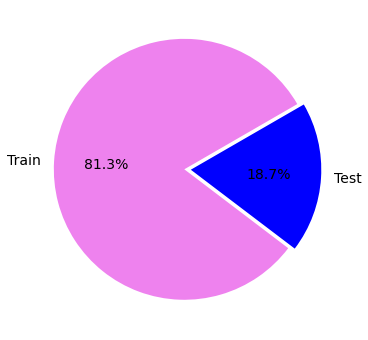

In [ ]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

### Defining Labels

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

### Loading Dataset

In [ ]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/content/', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
  # Join two or more pathname components
    folderPath = os.path.join('/content/', 'Testing', i) 
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)


100%|██████████| 300/300 [00:01<00:00, 241.93it/s]


In [ ]:
#Numbers of sample = 7023
X_train.shape 

(7023, 150, 150, 3)

In [ ]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [ ]:
#After shuffling sample size remains same
X_train.shape

(7023, 150, 150, 3)

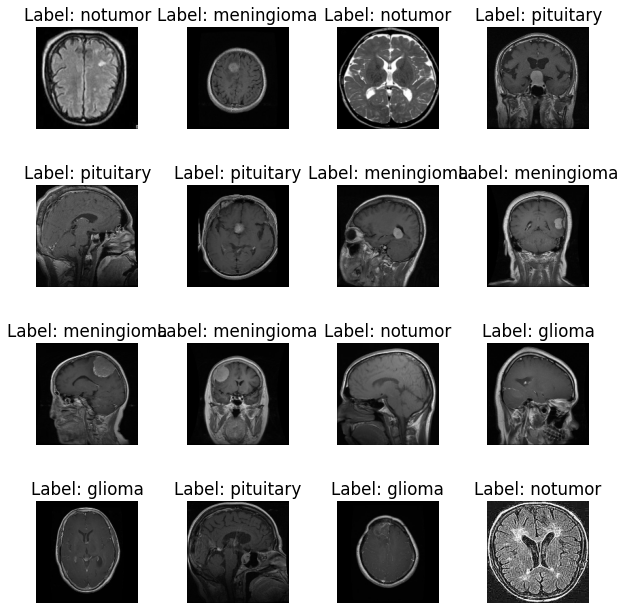

In [ ]:
#Vizualise some shuffled data in a grid form 
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  


### Splitting data into : Train, Test, Valid as 70, 20, 10 ratio

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

### Converting String Label to categorical

In [ ]:
y_train_new = []
y_valid_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # glioma ---> 0, meningioma---> 1, notumor ---> 2, pituitary ---> 3
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_valid:
    y_valid_new.append(labels.index(i))

Y_valid = to_categorical(y_valid_new)

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [ ]:
Y_train

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

## Simple CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['Acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

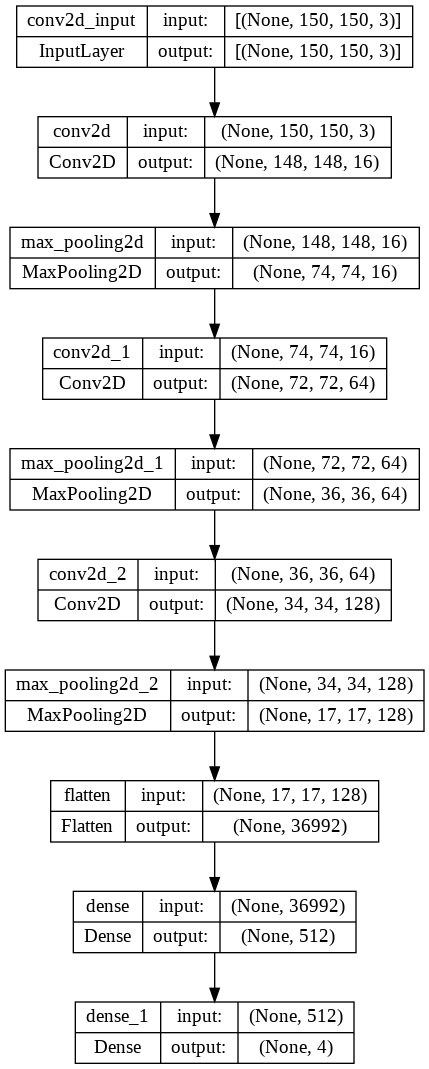

In [ ]:
plot_model(model, show_shapes=True)

### Scaling Features : Train, Valid and Test

In [ ]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

### Training the model

In [ ]:
history = model.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=32,
                   epochs=6,
                   verbose=1)

Epoch 1/6
158/158 [==============================] - 190s 1s/step - loss: 0.6900 - Acc: 0.7352 - val_loss: 0.6775 - val_Acc: 0.7367
Epoch 2/6
158/158 [==============================] - 190s 1s/step - loss: 0.3103 - Acc: 0.8845 - val_loss: 0.2770 - val_Acc: 0.9075
Epoch 3/6
158/158 [==============================] - 189s 1s/step - loss: 0.1534 - Acc: 0.9472 - val_loss: 0.1959 - val_Acc: 0.9395
Epoch 4/6
158/158 [==============================] - 196s 1s/step - loss: 0.0951 - Acc: 0.9678 - val_loss: 0.1486 - val_Acc: 0.9520
Epoch 5/6
158/158 [==============================] - 205s 1s/step - loss: 0.0664 - Acc: 0.9777 - val_loss: 0.1584 - val_Acc: 0.9573
Epoch 6/6
158/158 [==============================] - 193s 1s/step - loss: 0.0331 - Acc: 0.9899 - val_loss: 0.2050 - val_Acc: 0.9377


### Accuracy and Loss Visualization

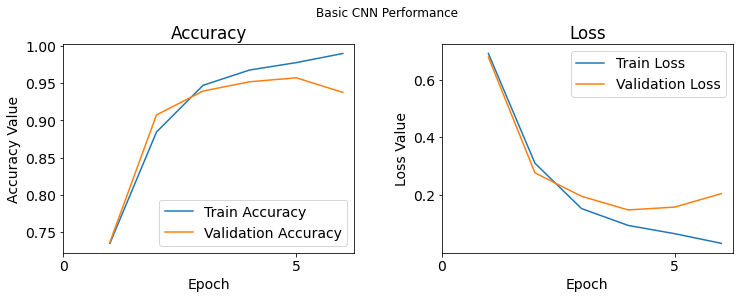

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,7))
ax1.plot(epoch_list, history.history['Acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_Acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 7, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 7, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Model Saving

In [ ]:
model.save('Basic_CNN.h5')

### Getting model predictions : Classification Report

In [ ]:
test_predictions = model.predict(X_test_scaled)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

44/44 [==============================] - 14s 324ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       310
           1       0.94      0.76      0.84       326
           2       0.93      0.99      0.96       419
           3       0.91      0.99      0.95       350

    accuracy                           0.92      1405
   macro avg       0.93      0.92      0.92      1405
weighted avg       0.93      0.92      0.92      1405



### Showing Confusion Matrix

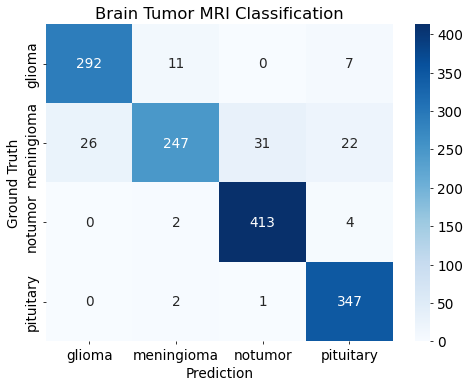

In [ ]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

### Plotting roc curve

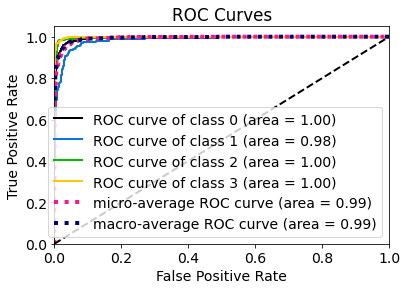

In [ ]:
skplt.metrics.plot_roc(actual_label, test_predictions)

### Visualizing Model Predictions with Confidence - CNN

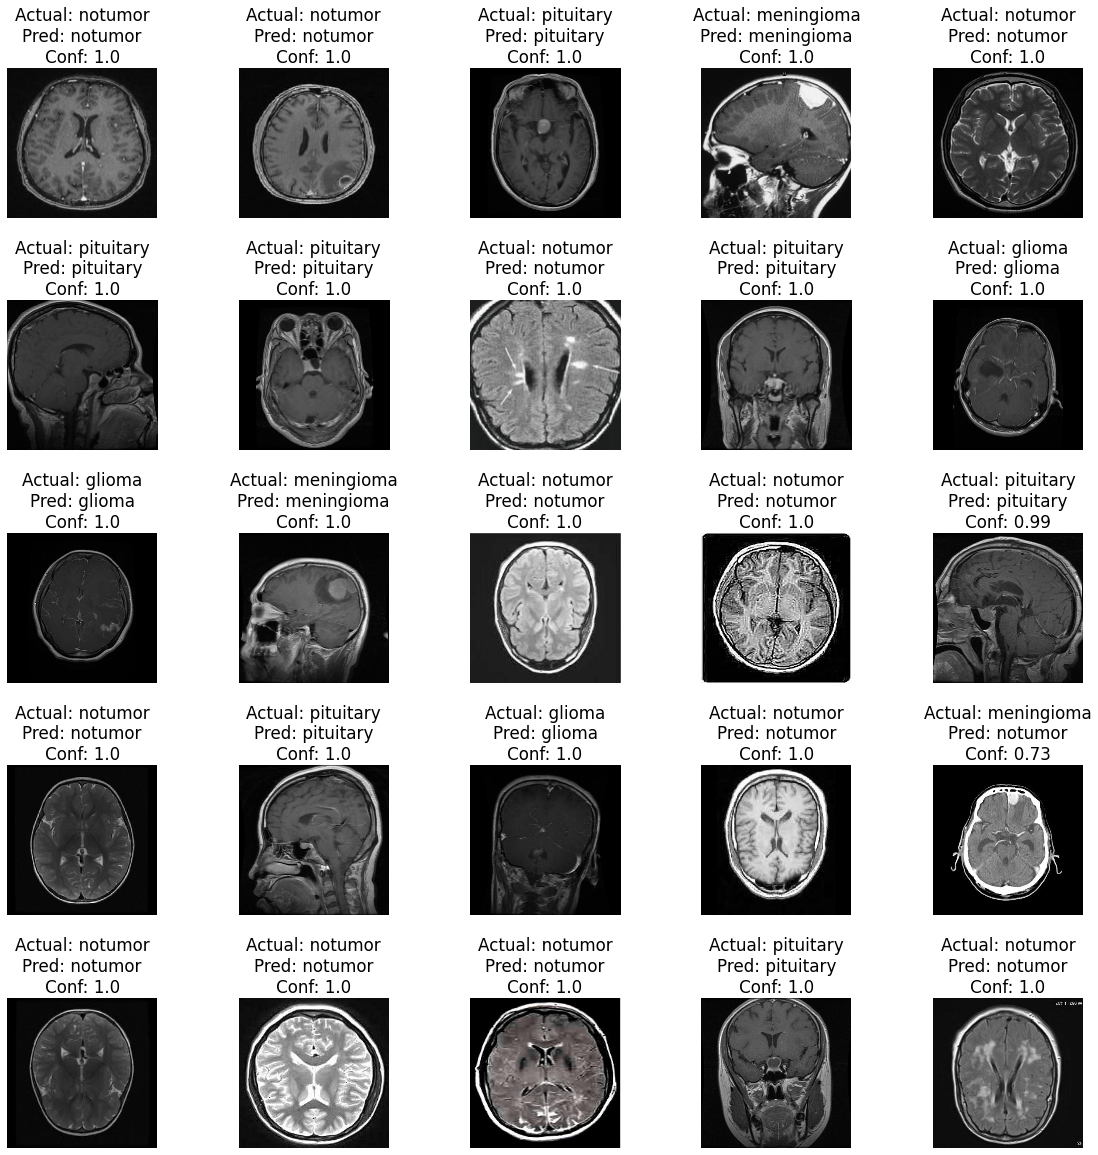

In [ ]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = preds[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+labels[actual]+'\nPred: '+labels[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)   